In [1]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [51]:
import glaft
# import matplotlib
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from matplotlib import colors, cm
# from matplotlib.colors import ListedColormap
# import rasterio
# from rasterio.plot import show
import numpy as np
import pandas as pd
# import geopandas as gpd
import netCDF4 as nc

In [42]:
df = pd.read_csv('../manifest_ITSLIVE.csv', dtype=str)
# df = pd.read_csv('../results_ITSLIVE.csv', dtype=str)
df

,Label,Start date,End date,Duration (days),Template size (px),Template size (m),Pixel spacing (px),Pixel spacing (m),Prefilter,Subpixel,Software,Vx,Vy
0,LS8-20180304-20180405,20180304,20180405,32,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...
1,LS8-20180405-20180421,20180405,20180421,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...
2,LS8-20180421-20180523,20180421,20180523,32,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...
3,LS8-20180523-20180608,20180523,20180608,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...
4,LS8-20180412-20180428,20180412,20180428,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...
5,LS8-20180428-20180802,20180428,20180802,96,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...
6,LS8-20180802-20180818,20180802,20180818,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...
7,LS8-20180818-20180903,20180818,20180903,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...
8,LS8-20180903-20181005,20180903,20181005,32,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...
9,Sen2-20180306-20180316,20180306,20180316,10,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...


In [45]:
for idx, row in df.iterrows():
    ncfname_processed = row.Vx[:-7]
    ncfname_list = ncfname_processed.split('/')
    ncfname_list.append(ncfname_list[-1])
    ncfname_list[-2] = 'raw_nc'
    ncfname = '/'.join(ncfname_list)
    with nc.Dataset(ncfname) as ds:
        vxd = ds['vx']
        xe = vxd.__dict__['error']
        # print(xe)
        vyd = ds['vy']
        ye = vyd.__dict__['error']
        # print(ye)
        df.loc[idx, 'Assigned-x-error'] = xe
        df.loc[idx, 'Assigned-y-error'] = ye
        
df

,Label,Start date,End date,Duration (days),Template size (px),Template size (m),Pixel spacing (px),Pixel spacing (m),Prefilter,Subpixel,Software,Vx,Vy,Assigned-x-error,Assigned-y-error
0,LS8-20180304-20180405,20180304,20180405,32,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,47.7,32.6
1,LS8-20180405-20180421,20180405,20180421,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,119.6,71.7
2,LS8-20180421-20180523,20180421,20180523,32,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,92.5,48.2
3,LS8-20180523-20180608,20180523,20180608,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,75.5,64.0
4,LS8-20180412-20180428,20180412,20180428,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,132.2,68.8
5,LS8-20180428-20180802,20180428,20180802,96,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,32.0,18.5
6,LS8-20180802-20180818,20180802,20180818,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,48.3,44.9
7,LS8-20180818-20180903,20180818,20180903,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,49.9,47.6
8,LS8-20180903-20181005,20180903,20181005,32,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,38.7,30.8
9,Sen2-20180306-20180316,20180306,20180316,10,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,102.3,62.4


In [46]:
# static area
in_shp = '../../data/shapefiles/bedrock_V1_EPSG3413.shp'

Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent


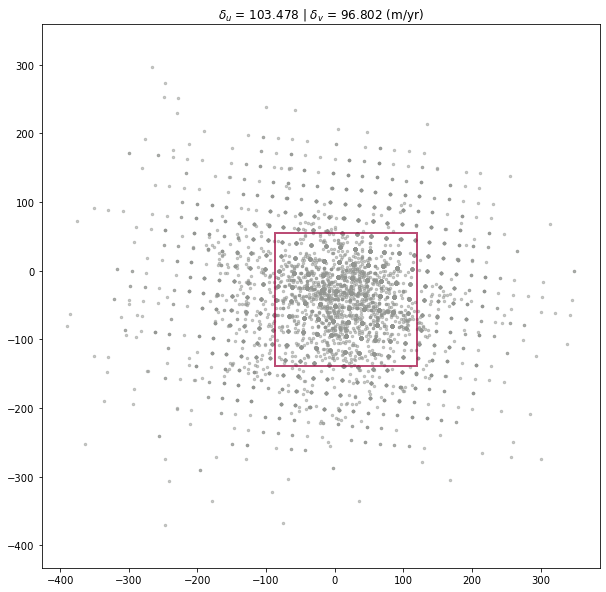

In [47]:
exp = glaft.Velocity(vxfile=df.loc[4, 'Vx'], vyfile=df.loc[4, 'Vy'], static_area=in_shp, kde_gridsize=60, thres_sigma=2.0, velocity_unit='m/yr')
exp.static_terrain_analysis(plot='full')

Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
xstd: 38.55387878417969; xSAVuncer: 54.6898472387492
ystd: 32.52314376831055; ySAVuncer: 44.43550088148372
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
xstd: 122.16836547851562; xSAVuncer: 139.11564778386023
ystd: 86.74234008789062; ySAVuncer: 121.72619181087768
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh

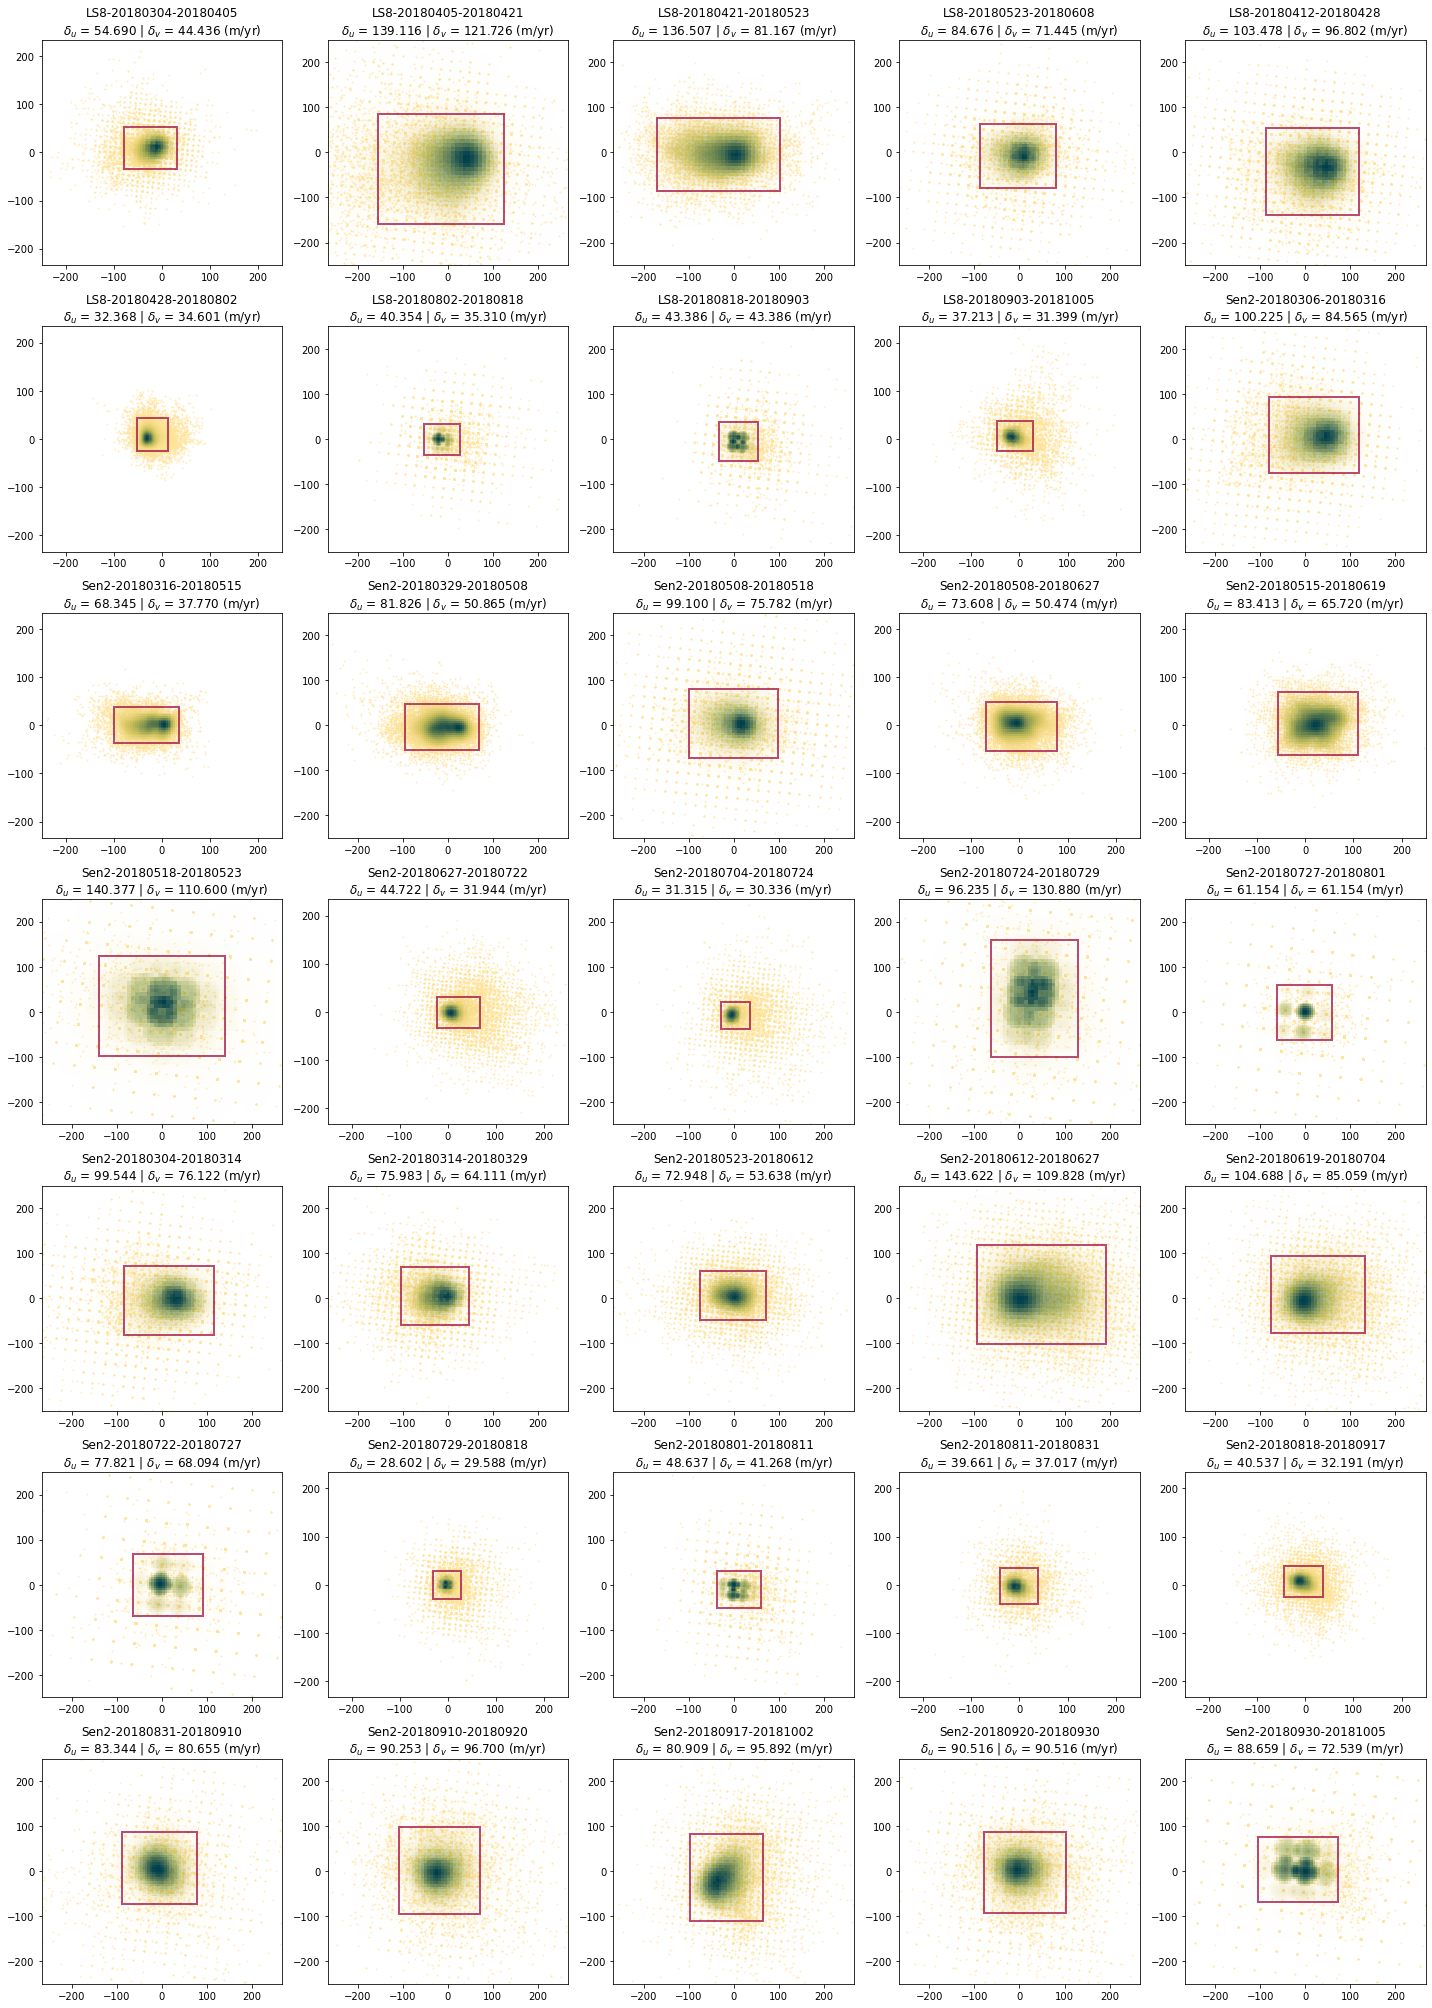

In [52]:
fig, ax2 = plt.subplots(7, 5, figsize=(20, 28))
n = 0 

for idx, row in df.iterrows():
    label = row.Label
    ax_sel = ax2[n // 5, n % 5]
    ax_sel.axis('equal')
    exp = glaft.Velocity(vxfile=row.Vx, vyfile=row.Vy, static_area=in_shp, kde_gridsize=60, thres_sigma=2.0, velocity_unit='m/yr')
    exp.static_terrain_analysis(plot='zoomed', ax=ax_sel)
    ax_sel.set_xlim(-250, 250)
    ax_sel.set_ylim(-250, 250)
    titletext = ax_sel.get_title()
    titletext = label + '\n' + titletext
    ax_sel.set_title(titletext)
    
    df.loc[idx, 'SAV-uncertainty-x'] = exp.metric_static_terrain_x
    df.loc[idx, 'SAV-uncertainty-y'] = exp.metric_static_terrain_y
    df.loc[idx, 'SAV-peak-x'] = exp.kdepeak_x
    df.loc[idx, 'SAV-peak-y'] = exp.kdepeak_y
    df.loc[idx, 'SAV-outlier-percent'] = exp.outlier_percent * 100
    
    print('xstd: {}; xSAVuncer: {}'.format(np.std(exp.xy[0, :]), exp.metric_static_terrain_x))
    print('ystd: {}; ySAVuncer: {}'.format(np.std(exp.xy[1, :]), exp.metric_static_terrain_y))
    
    n += 1
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')
fig.savefig('figs/ITSLVE-SAV.png')

In [7]:
# for i in range(n, 48):
#     ax_sel = ax2[i // 6, i % 6]
#     fig.delaxes(ax_sel)


In [49]:
df

,Label,Start date,End date,Duration (days),Template size (px),Template size (m),Pixel spacing (px),Pixel spacing (m),Prefilter,Subpixel,Software,Vx,Vy,Assigned-x-error,Assigned-y-error,SAV-uncertainty-x,SAV-uncertainty-y,SAV-peak-x,SAV-peak-y,SAV-outlier-percent
0,LS8-20180304-20180405,20180304,20180405,32,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,47.7,32.6,54.689847,44.435501,-10.036596,12.709058,24.234744
1,LS8-20180405-20180421,20180405,20180421,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,119.6,71.7,139.115648,121.726192,37.126276,-9.957908,26.926534
2,LS8-20180421-20180523,20180421,20180523,32,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,92.5,48.2,136.507497,81.166620,6.204526,-4.689392,16.207433
3,LS8-20180523-20180608,20180523,20180608,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,75.5,64.0,84.675501,71.444954,7.938328,-10.938328,25.965909
4,LS8-20180412-20180428,20180412,20180428,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,132.2,68.8,103.477918,96.801923,46.365981,-31.662003,22.752202
5,LS8-20180428-20180802,20180428,20180802,96,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,32.0,18.5,32.368467,34.600775,-29.348462,1.651538,23.938585
6,LS8-20180802-20180818,20180802,20180818,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,48.3,44.9,40.353957,35.309713,-20.783183,-1.261061,30.545368
7,LS8-20180818-20180903,20180818,20180903,16,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,49.9,47.6,43.385667,43.385667,0.199544,-3.876678,25.418117
8,LS8-20180903-20181005,20180903,20181005,32,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,38.7,30.8,37.213388,31.398796,-14.814592,4.837082,31.191852
9,Sen2-20180306-20180316,20180306,20180316,10,NaN,varying (240-480),NaN,120,ITS_LIVE (5x5 Wallis operator),ITS_LIVE (16-node oversampling),ITS_LIVE (autoRIFT),/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,/home/jovyan/Projects/PX_comparison/PX/ITS_LIV...,102.3,62.4,100.225432,84.565209,44.924313,5.132045,24.211789


In [53]:
df.to_csv('../results_ITSLIVE.csv', index=False)
# df